In [1]:
# Import các thư viện cần thiết
import torch
import learn2learn as l2l
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Load dữ liệu
data = pd.read_csv("../../../Dataset/ADBE_Stock.csv")

In [5]:
data

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,3/1/2019,ADBE,264.010010,264.010010,266.239990,261.500000,265.750000,2594000
1,3/4/2019,ADBE,258.160004,258.160004,267.000000,254.080002,266.700012,2994900
2,3/5/2019,ADBE,257.380005,257.380005,259.869995,256.369995,259.000000,2101800
3,3/6/2019,ADBE,256.399994,256.399994,259.489990,253.839996,257.399994,1950500
4,3/7/2019,ADBE,255.460007,255.460007,257.489990,253.289993,255.770004,3185200
...,...,...,...,...,...,...,...,...
1319,5/28/2024,ADBE,478.429993,478.429993,478.670013,469.600006,473.010010,2575300
1320,5/29/2024,ADBE,477.600006,477.600006,482.790008,472.600006,472.779999,2214800
1321,5/30/2024,ADBE,445.869995,445.869995,466.820007,444.839996,464.899994,5606900
1322,5/31/2024,ADBE,444.760010,444.760010,448.230011,433.970001,447.720001,7487500


In [6]:
data.describe()

,Adj Close,Close,High,Low,Open,Volume
count,1324.000000,1324.000000,1324.000000,1324.000000,1324.000000,1.324000e+03
mean,437.561171,437.561171,442.956797,431.746496,437.548852,2.987458e+06
std,112.802864,112.802864,113.786692,111.798628,112.881015,1.733830e+06
min,254.740005,254.740005,255.020004,249.100006,251.490005,5.892000e+05
25%,339.532501,339.532501,344.690010,333.492500,338.960007,2.039850e+06
50%,443.785004,443.785004,449.224991,436.915009,444.769989,2.573100e+06
75%,514.142502,514.142502,520.422485,508.869987,514.000000,3.413750e+06
max,688.369995,688.369995,699.539978,678.909973,696.280029,2.784020e+07


In [7]:
# Check Null
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1324 non-null   object 
 1   Symbol     1324 non-null   object 
 2   Adj Close  1324 non-null   float64
 3   Close      1324 non-null   float64
 4   High       1324 non-null   float64
 5   Low        1324 non-null   float64
 6   Open       1324 non-null   float64
 7   Volume     1324 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 82.9+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
def detect_outlier(df, col):
    q1 = np.percentile(df[col], 25)
    q3 = np.percentile(df[col], 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(df[(df[col] < lower_bound) | (df[col] > upper_bound)])

In [9]:
detect_outlier(data, 'Close')

Empty DataFrame
Columns: [Date, Symbol, Adj Close, Close, High, Low, Open, Volume]
Index: []


Không có outliers

In [10]:
df=data.reset_index()['Close']

In [11]:
df

0       264.010010
1       258.160004
2       257.380005
3       256.399994
4       255.460007
           ...    
1319    478.429993
1320    477.600006
1321    445.869995
1322    444.760010
1323    439.019989
Name: Close, Length: 1324, dtype: float64

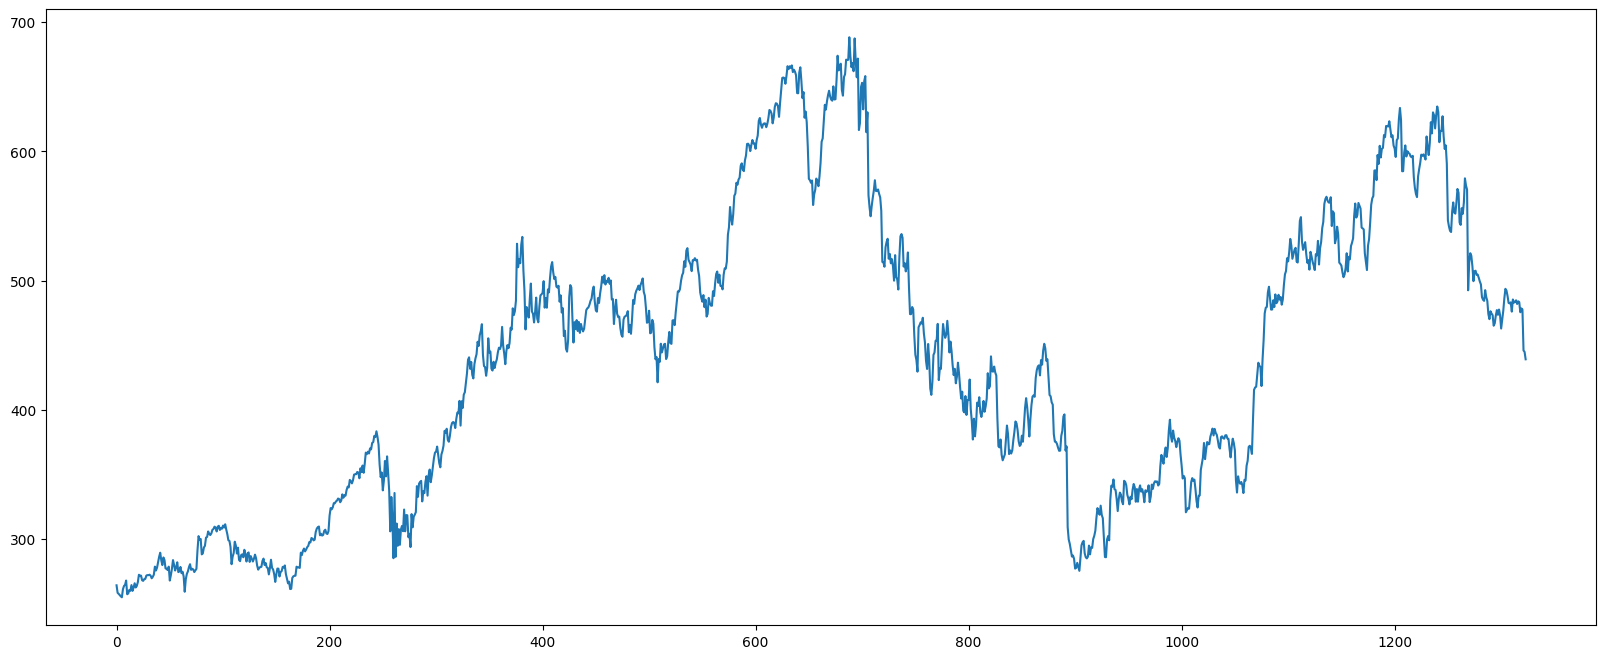

In [12]:
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.show()

In [13]:
# Chuẩn hóa dữ liệu sử dụng MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))

In [14]:
df

array([[0.02137768],
       [0.0078869 ],
       [0.00608814],
       ...,
       [0.44076746],
       [0.43820771],
       [0.42497057]])

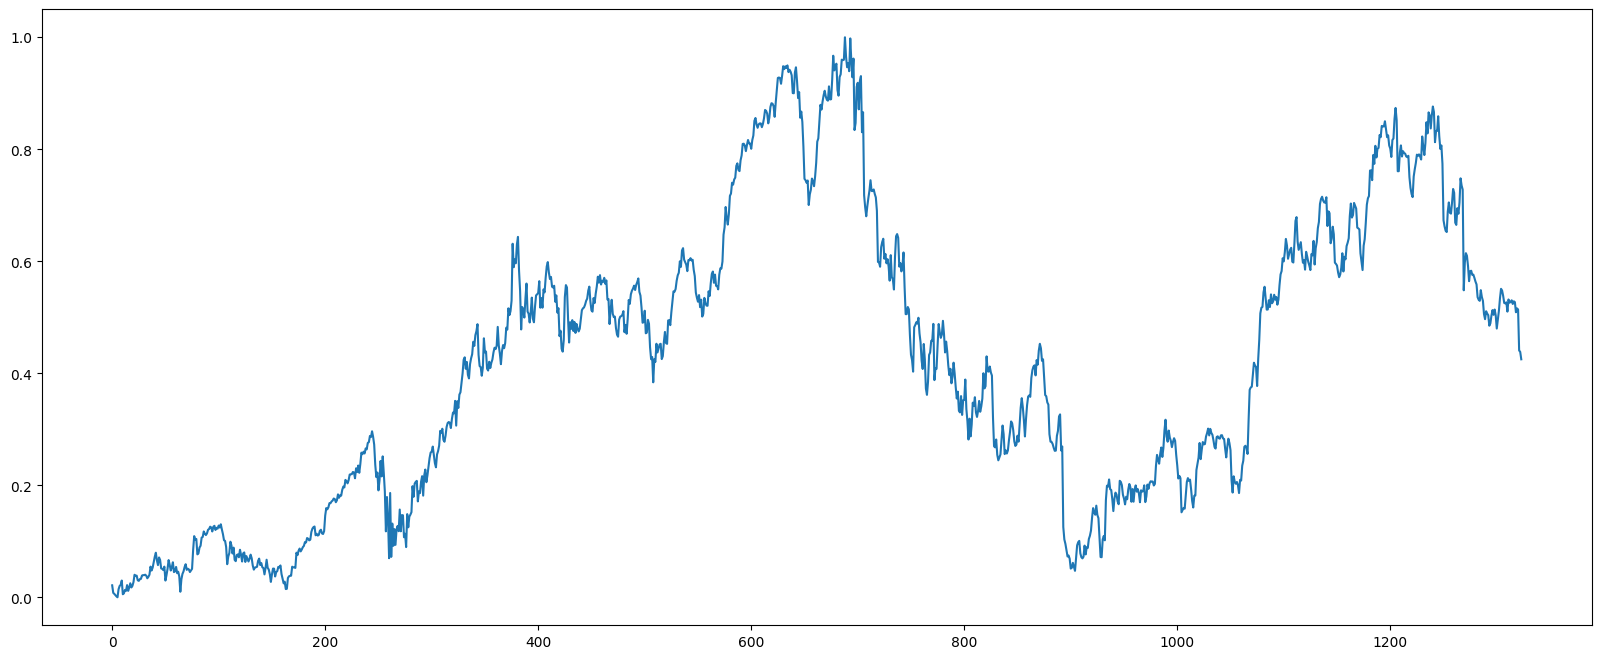

In [15]:
plt.figure(figsize=(20, 8))
plt.plot(df)
plt.show()

In [16]:
# Chia train test
train_size = int(0.7 * len(df))
test_size = len(df) - train_size

train_data = df[:train_size]
test_data = df[train_size:]

In [17]:
# Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
# Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [20]:
# Tạo DataLoader
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(ytest))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [21]:
# Xây dựng mô hình
class StockPredictor(nn.Module):
    def __init__(self):
        super(StockPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=24, num_layers=2, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(24, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

In [22]:
# Định nghĩa hàm meta-learning
def fast_adapt(batch, learner, loss, adaptation_steps, device):
    data, labels = batch
    data, labels = data.to(device), labels.to(device)
    for step in range(adaptation_steps):
        predictions = learner(data).view(-1)
        train_loss = loss(predictions, labels.view(-1))
        learner.adapt(train_loss)
    return train_loss

In [23]:
# Định nghĩa quá trình training
def meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps, meta_batch_size, device):
    for epoch in range(100):
        meta_loss = 0.0
        for batch in train_loader:
            learner = maml.clone()
            batch_loss = fast_adapt(batch, learner, loss, adaptation_steps, device)
            meta_loss += batch_loss.item()
            meta_optimizer.zero_grad()
            batch_loss.backward()
            # Ensure that only leaf tensors are used to calculate the gradients
            for param in maml.parameters():
                if param.grad is not None:
                    param.grad = param.grad.clone().detach()
            meta_optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {meta_loss/len(train_loader)}')

In [24]:
# Khởi tạo mô hình và các thành phần cần thiết
device = torch.device('cpu')
model = StockPredictor().to(device)
maml = l2l.algorithms.MAML(model, lr=0.01)
meta_optimizer = optim.Adam(maml.parameters(), lr=0.001)
loss = nn.MSELoss()

In [25]:
# Training mô hình
meta_train(maml, train_loader, meta_optimizer, loss, adaptation_steps=3, meta_batch_size=28, device=device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:810: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad


Epoch 1, Loss: 0.26346581601179564
Epoch 2, Loss: 0.10273921375091259
Epoch 3, Loss: 0.05628692989165966
Epoch 4, Loss: 0.0459891574887129
Epoch 5, Loss: 0.035717492923140526
Epoch 6, Loss: 0.020937403878913477
Epoch 7, Loss: 0.008233970890824612
Epoch 8, Loss: 0.006332127269930565
Epoch 9, Loss: 0.005104137674117317
Epoch 10, Loss: 0.004555036761583044
Epoch 11, Loss: 0.0043262684216293
Epoch 12, Loss: 0.0042981425873362105
Epoch 13, Loss: 0.003987020096526696
Epoch 14, Loss: 0.004167332546785474
Epoch 15, Loss: 0.003625212613349924
Epoch 16, Loss: 0.0032863573780140052
Epoch 17, Loss: 0.003467499600866666
Epoch 18, Loss: 0.0033176036444134437
Epoch 19, Loss: 0.003332065400452568
Epoch 20, Loss: 0.0031969315157486843
Epoch 21, Loss: 0.003121385180677932
Epoch 22, Loss: 0.0029567148124512574
Epoch 23, Loss: 0.0029861689007912692
Epoch 24, Loss: 0.002948117764809957
Epoch 25, Loss: 0.0027229527566725244
Epoch 26, Loss: 0.00267488168230137
Epoch 27, Loss: 0.0026656946865841746
Epoch 28, 

In [26]:
# Dự đoán và hiển thị kết quả trên tập test
model.eval()
predictions = []
with torch.no_grad():
    for i in range(len(X_test)):
        x = torch.Tensor(X_test[i:i+1]).to(device)
        pred = model(x).cpu().numpy()
        predictions.append(pred)

predictions = np.array(predictions).flatten()
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [27]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#  Tính MAE
def calculate_mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = np.mean(np.abs(y_true - y_pred))
    return mae

# Tính toán RMSE, MAPE và MDA
test_rmse = np.sqrt(np.mean((predictions - ytest) ** 2))
test_mape = calculate_mape(ytest, predictions)
test_mae = calculate_mae(ytest, predictions)

# In kết quả
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('Testing MAE:', test_mae)

Testing RMSE: 110.12767363480398
Testing MAPE: 18.239436178171086
Testing MAE: 87.18104668813517


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_30 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 30):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_30.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_30.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_30_days = scaler.inverse_transform(np.array(lst_output_30).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 30 ngày tiếp theo:")
print(predicted_30_days)


Dự báo 30 ngày tiếp theo:
[[461.87504684]
 [456.95935319]
 [454.69637501]
 [454.20919694]
 [454.91679278]
 [456.39993455]
 [458.36226785]
 [460.60296647]
 [462.99339306]
 [465.45647377]
 [467.95072519]
 [470.45771887]
 [472.97288   ]
 [475.49943937]
 [478.04440136]
 [480.61580417]
 [483.22168603]
 [485.86892207]
 [488.5634311 ]
 [491.30983962]
 [494.11174029]
 [496.97174357]
 [499.89199473]
 [502.87373437]
 [505.91807391]
 [509.02565949]
 [512.19693051]
 [515.43209373]
 [518.73112331]
 [522.0939934 ]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# Dự báo 60 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output_60 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 60):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_60.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_60_days = scaler.inverse_transform(np.array(lst_output_60).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 60 ngày tiếp theo:")
print(predicted_60_days)


Dự báo 60 ngày tiếp theo:
[[461.87504684]
 [456.95935319]
 [454.69637501]
 [454.20919694]
 [454.91679278]
 [456.39993455]
 [458.36226785]
 [460.60296647]
 [462.99339306]
 [465.45647377]
 [467.95072519]
 [470.45771887]
 [472.97288   ]
 [475.49943937]
 [478.04440136]
 [480.61580417]
 [483.22168603]
 [485.86892207]
 [488.5634311 ]
 [491.30983962]
 [494.11174029]
 [496.97174357]
 [499.89199473]
 [502.87373437]
 [505.91807391]
 [509.02565949]
 [512.19693051]
 [515.43209373]
 [518.73112331]
 [522.0939934 ]
 [525.52023878]
 [529.0093425 ]
 [532.56060672]
 [536.17299759]
 [539.84532617]
 [543.57591245]
 [547.36299887]
 [551.20433681]
 [555.09736747]
 [559.03904099]
 [563.02599733]
 [567.05441123]
 [571.11994051]
 [575.21788112]
 [579.34301211]
 [583.48964727]
 [587.65171271]
 [591.82259175]
 [595.99528004]
 [600.16241137]
 [604.3163869 ]
 [608.44906502]
 [612.55230414]
 [616.61770419]
 [620.63678755]
 [624.60107663]
 [628.50214551]
 [632.33182674]
 [636.0820821 ]
 [639.7453903 ]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [30]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])


lst_output_90 = []
n_steps = x_input.shape[1]
i = 0

model.eval()
while (i < 90):
    if (len(temp_input) > n_steps):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        x_tensor = torch.Tensor(x_input).to(device)
        with torch.no_grad():
            yhat = model(x_tensor).cpu().numpy()
        temp_input.extend(yhat[0].tolist())
        lst_output_90.extend(yhat.tolist())
        i = i + 1

# Chuyển đổi kết quả dự đoán trở lại dạng giá trị ban đầu
predicted_90_days = scaler.inverse_transform(np.array(lst_output_90).reshape(-1, 1))

# Hiển thị kết quả
print("Dự báo 90 ngày tiếp theo:")
print(predicted_90_days)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dự báo 90 ngày tiếp theo:
[[461.87504684]
 [456.95935319]
 [454.69637501]
 [454.20919694]
 [454.91679278]
 [456.39993455]
 [458.36226785]
 [460.60296647]
 [462.99339306]
 [465.45647377]
 [467.95072519]
 [470.45771887]
 [472.97288   ]
 [475.49943937]
 [478.04440136]
 [480.61580417]
 [483.22168603]
 [485.86892207]
 [488.5634311 ]
 [491.30983962]
 [494.11174029]
 [496.97174357]
 [499.89199473]
 [502.87373437]
 [505.91807391]
 [509.02565949]
 [512.19693051]
 [515.43209373]
 [518.73112331]
 [522.0939934 ]
 [525.52023878]
 [529.0093425 ]
 [532.56060672]
 [536.17299759]
 [539.84532617]
 [543.57591245]
 [547.36299887]
 [551.20433681]
 [555.09736747]
 [559.03904099]
 [563.02599733]
 [567.05441123]
 [571.11994051]
 [575.21788112]
 [579.34301211]
 [583.48964727]
 [587.65171271]
 [591.82259175]
 [595.99528004]
 [600.16241137]
 [604.3163869 ]
 [608.44906502]
 [612.55230414]
 [616.61770419]
 [620.63678755]
 [624.60107663]
 [628.50214551]
 [632.33182674]
 [636.0820821 ]
 [639.7453903 ]
 [643.31446267

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


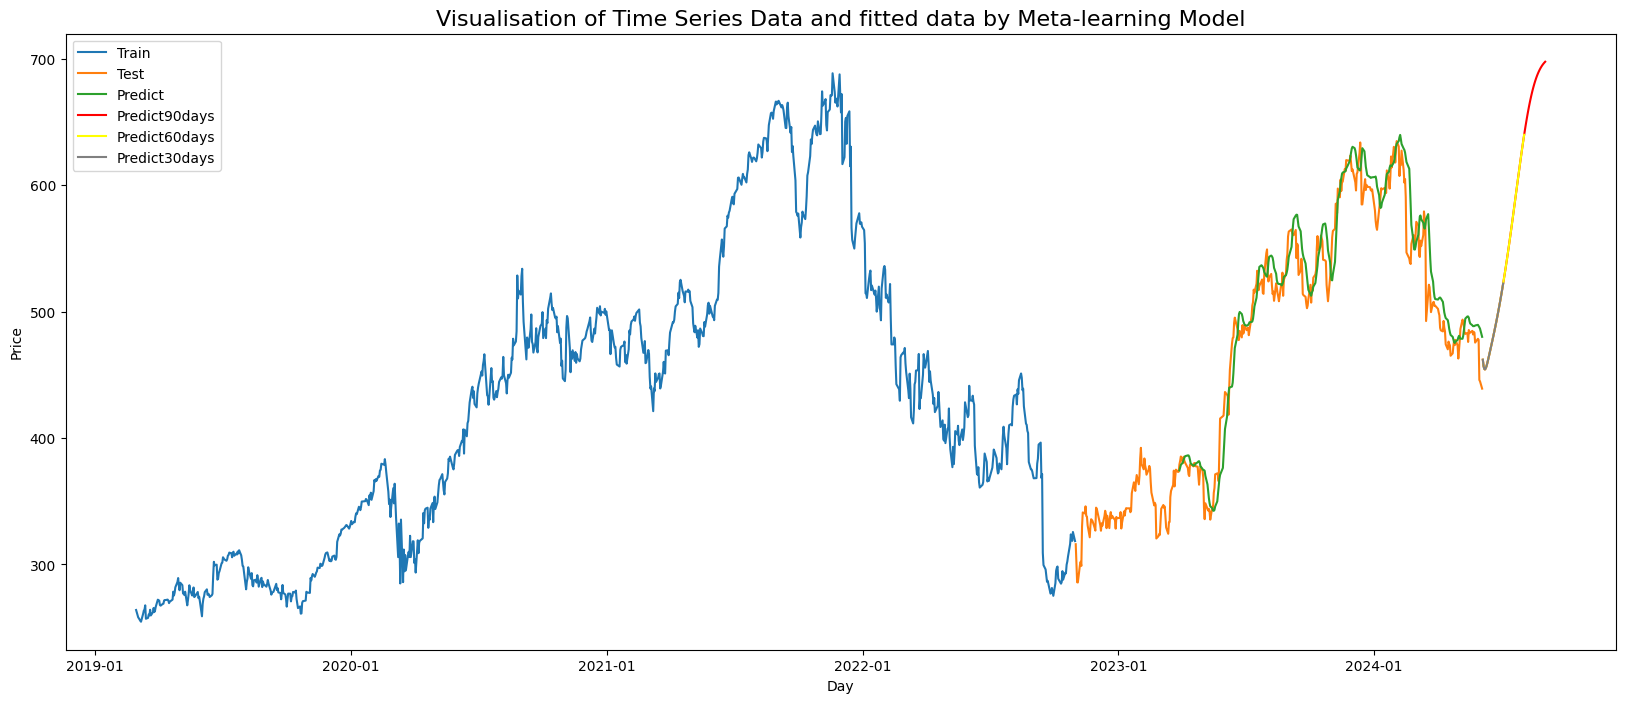

In [31]:
# 14.Vẽ hình
import matplotlib.dates as mdates
plt.figure(figsize=(20, 8))

data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'][:train_size],scaler.inverse_transform(train_data))
plt.plot(data['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(data['Date'][train_size+101:],(predictions))

predict_data_index_90 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of Time Series Data and fitted data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


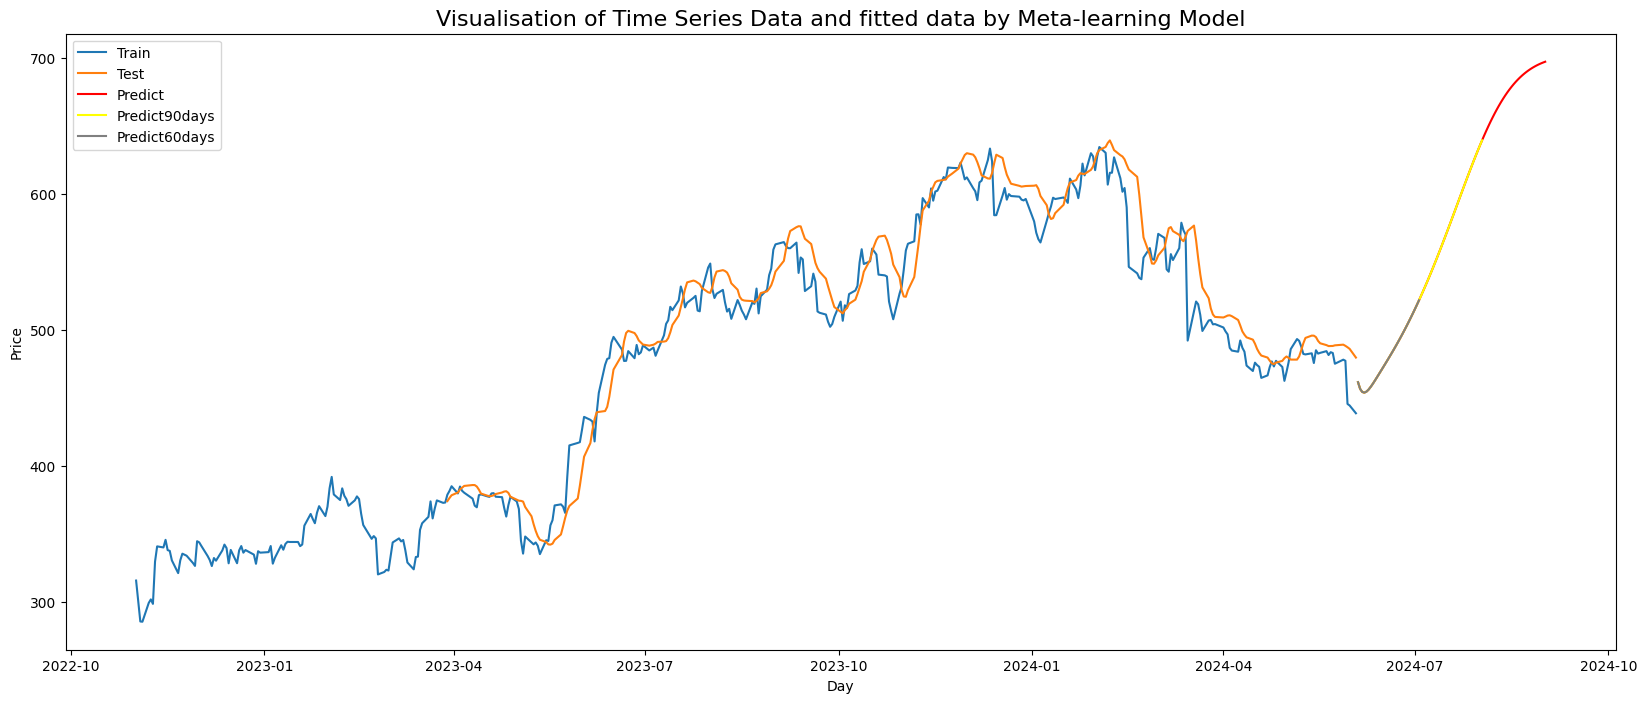

In [32]:
# 15.Vẽ hình test prediction
import matplotlib.dates as mdates
plt.figure(figsize=(20, 8))

data['Date'] = pd.to_datetime(data['Date'])
plt.plot(data['Date'][train_size:],scaler.inverse_transform(test_data))
plt.plot(data['Date'][train_size+101:],(predictions))

predict_data_index_90 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=90, freq='D')
predict_data_index_60 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=60, freq='D')
predict_data_index_30 = pd.bdate_range(start=data['Date'][len(data['Date'])-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Train','Test','Predict','Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of Time Series Data and fitted data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


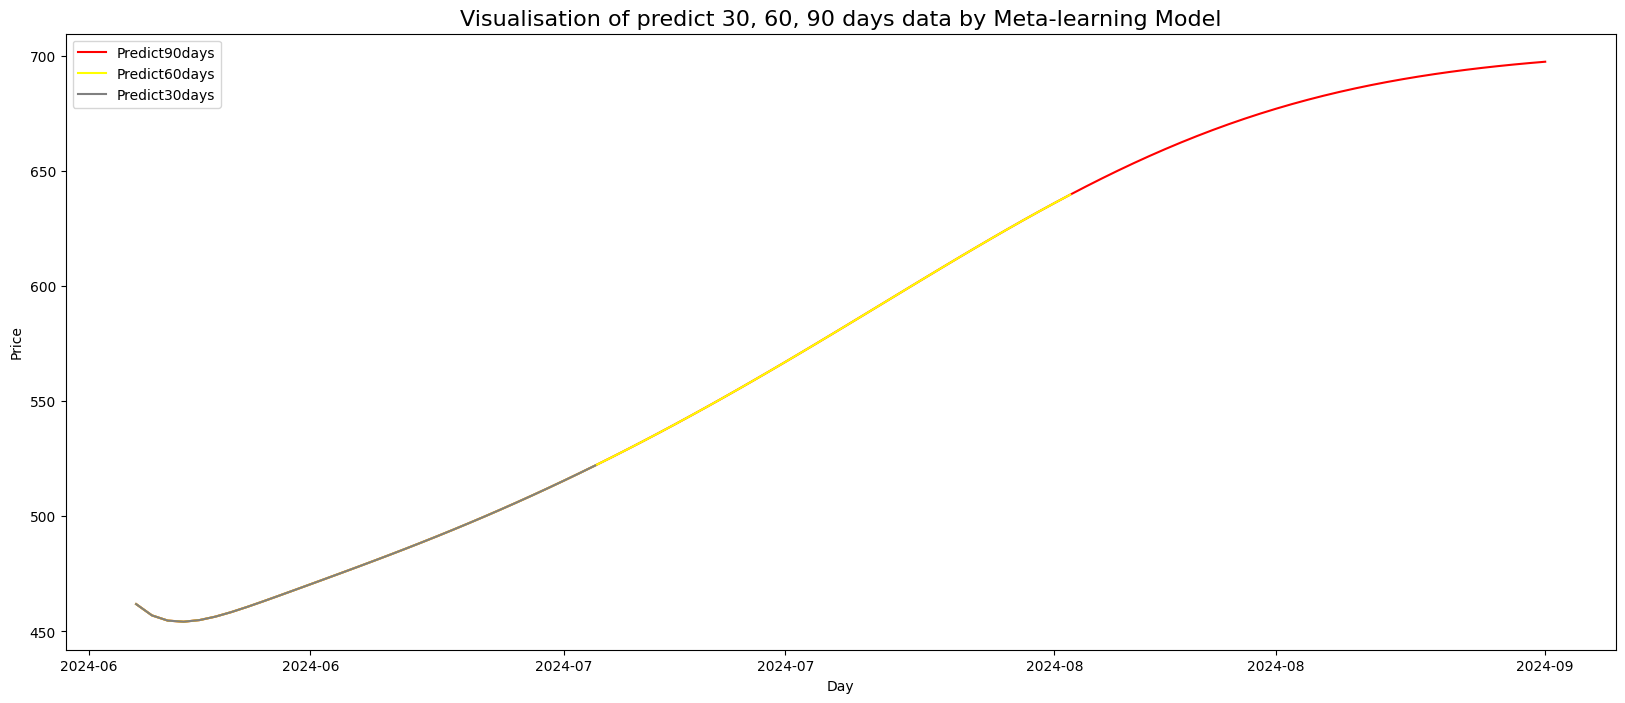

In [33]:
plt.figure(figsize=(20, 8))
plt.plot(predict_data_index_90,scaler.inverse_transform(lst_output_90), color='red')
plt.plot(predict_data_index_60,scaler.inverse_transform(lst_output_60), color='yellow')
plt.plot(predict_data_index_30,scaler.inverse_transform(lst_output_30), color='grey')
plt.legend(['Predict90days', 'Predict60days', 'Predict30days'])
plt.title('Visualisation of predict 30, 60, 90 days data by Meta-learning Model' , fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel('Day')
plt.ylabel('Price')
plt.show()